In [1]:
# read csv file and print out the data
import csv
import sys
import os
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

from helper import transform_polars_df

In [2]:
datapath = '../data/2011-2012 Solar home electricity data v2.csv'
# skip the first line in csv and read the next line as column
# then read the rest of the file and store as dataframe
df = pl.read_csv(datapath, skip_rows=1)
print(df)
print(df.columns)

shape: (270_304, 54)
┌──────────┬───────────┬──────────┬──────────────────────┬───┬───────┬───────┬───────┬─────────────┐
│ Customer ┆ Generator ┆ Postcode ┆ Consumption Category ┆ … ┆ 23:00 ┆ 23:30 ┆ 0:00  ┆ Row Quality │
│ ---      ┆ Capacity  ┆ ---      ┆ ---                  ┆   ┆ ---   ┆ ---   ┆ ---   ┆ ---         │
│ i64      ┆ ---       ┆ i64      ┆ str                  ┆   ┆ f64   ┆ f64   ┆ f64   ┆ str         │
│          ┆ f64       ┆          ┆                      ┆   ┆       ┆       ┆       ┆             │
╞══════════╪═══════════╪══════════╪══════════════════════╪═══╪═══════╪═══════╪═══════╪═════════════╡
│ 1        ┆ 3.78      ┆ 2076     ┆ CL                   ┆ … ┆ 0.0   ┆ 0.0   ┆ 1.063 ┆ null        │
│ 1        ┆ 3.78      ┆ 2076     ┆ GC                   ┆ … ┆ 0.118 ┆ 0.219 ┆ 0.162 ┆ null        │
│ 1        ┆ 3.78      ┆ 2076     ┆ GG                   ┆ … ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ null        │
│ 1        ┆ 3.78      ┆ 2076     ┆ CL                   ┆ … ┆ 0.0   ┆

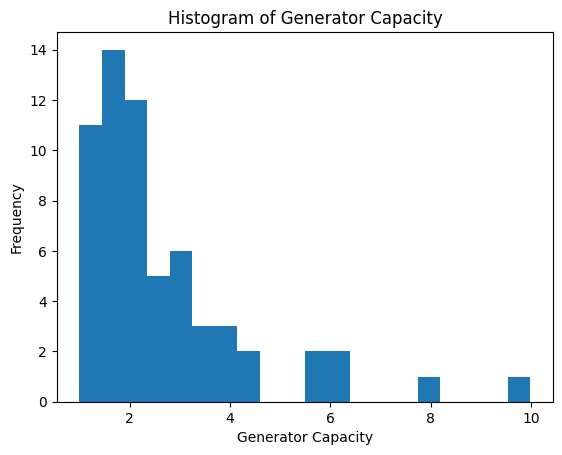

In [3]:
# show me different values in 'Generator Capacity'
GenCap = df['Generator Capacity'].unique()

# plot histogram of 'Generator Capacity'
plt.hist(GenCap, bins=20)
plt.xlabel('Generator Capacity')
plt.ylabel('Frequency')
plt.title('Histogram of Generator Capacity')
plt.show()


In [ ]:


# get all the unique customers as their own dataframes
customers = df['Customer'].unique()
# pick 80% of the random customers as training data
training_customers = np.random.choice(customers, int(0.8*len(customers)), replace=False)
# the rest of the customers are testing data
testing_customers = np.setdiff1d(customers, training_customers)

In [4]:
# save the customers number to a csv file
np.savetxt('../data/training_customers.csv', training_customers, fmt='%s')
np.savetxt('../data/testing_customers.csv', testing_customers, fmt='%s')

In [3]:
# alternatively, we can get the training and testing customers from the csv file
training_customers = np.loadtxt('../data/training_customers.csv', dtype=int)
testing_customers = np.loadtxt('../data/testing_customers.csv', dtype=int)

In [4]:
# loop through each customer and use transform_polars_df to get the dataframe and store it in a list call dataset
training_dataset = []
for customer in training_customers:
    customer_df = df.filter(pl.col('Customer') == customer)
    try:
        newcustomerdf = transform_polars_df(customer_df, import_energy_price=0.15, export_energy_price=0.1, price_periods="7am – 10am | 4pm – 9pm", default_import_energy_price=0.1, default_export_energy_price=0.08)
    except Exception as e:
        print(f"Error with customer as training dataset: {customer}")
        print(e)
        break
    training_dataset.append(newcustomerdf)

testing_dataset = []
for customer in testing_customers:
    customer_df = df.filter(pl.col('Customer') == customer)
    try:
        newcustomerdf = transform_polars_df(customer_df, import_energy_price=0.15, export_energy_price=0.1, price_periods="7am – 10am | 4pm – 9pm", default_import_energy_price=0.1, default_export_energy_price=0.08)
    except Exception as e:
        print(f"Error with customer as testing dataset: {customer}")
        print(e)
        break
    testing_dataset.append(newcustomerdf)


In [5]:
import gymnasium as gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_checker import check_env
from EnergySimEnv import SolarBatteryEnv


# Helper: create an environment instance from a dataset.
def make_env(dataset):
    def _init():
        env = SolarBatteryEnv(dataset, max_step=len(dataset)-1)
        return env
    return _init

# Create a list of environment creation functions to build a vectorized environment.
env_fns = [make_env(ds) for ds in training_dataset]
vec_env = DummyVecEnv(env_fns)

num_total_steps = len(training_dataset[0])*len(training_dataset)
print(f"Total number of steps possible in training dataset: {num_total_steps}")

testing_env_fns = [make_env(ds) for ds in testing_dataset]


Total number of steps possible in training dataset: 4216080


/usr/local/lib/python3.10/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [6]:
evaluation_results = {}

In [7]:
import optuna
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

def optimize_ppo(trial):
    # Sample hyperparameters
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
    gamma = trial.suggest_uniform("gamma", 0.90, 0.999)
    clip_range = trial.suggest_uniform("clip_range", 0.1, 0.3)
    ent_coef = trial.suggest_loguniform("ent_coef", 1e-8, 1e-2)
    vf_coef = trial.suggest_uniform("vf_coef", 0.1, 1.0)
    
    # Choose network architecture preset
    net_arch_choice = trial.suggest_categorical("net_arch", ["small", "medium", "large"])
    if net_arch_choice == "small":
        net_arch = [64, 64]
    elif net_arch_choice == "medium":
        net_arch = [256, 256]
    else:
        net_arch = [400, 300]
    policy_kwargs = dict(net_arch=net_arch)
    
    # Instantiate PPO with the trial hyperparameters
    model = PPO(
        "MlpPolicy",
        vec_env,
        verbose=0,
        learning_rate=learning_rate,
        gamma=gamma,
        clip_range=clip_range,
        ent_coef=ent_coef,
        vf_coef=vf_coef,
        policy_kwargs=policy_kwargs
    )
    
    # Train for a small number of timesteps for tuning
    model.learn(total_timesteps=40000)
    
    # Evaluate on the testing environment (Monitor-wrapped)
    mean_reward, _ = evaluate_policy(model, Monitor(testing_env_fns[0]()), n_eval_episodes=3, deterministic=False)
    return mean_reward

study = optuna.create_study(direction="maximize")
study.optimize(optimize_ppo, n_trials=20)
print("Best PPO trial:", study.best_trial.params)

[I 2025-03-27 15:40:13,830] A new study created in memory with name: no-name-3cbc8dc5-7b3a-4166-bbb2-f9c4dbdb315c
/tmp/ipykernel_399/1694649278.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
/tmp/ipykernel_399/1694649278.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform("gamma", 0.90, 0.999)
/tmp/ipykernel_399/1694649278.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  clip_range = trial.suggest_uniform("clip_range", 0.1, 0.3)
/tmp/ipyke

Best PPO trial: {'learning_rate': 0.0004921267105180336, 'gamma': 0.9414287353264155, 'clip_range': 0.12187518776978819, 'ent_coef': 3.1339086750943203e-07, 'vf_coef': 0.7332257033789507, 'net_arch': 'large'}


In [8]:
# Retrieve best parameters from the Optuna study
best_params = study.best_trial.params

# Determine network architecture based on the best net_arch choice
if best_params["net_arch"] == "small":
    net_arch = [64, 64]
elif best_params["net_arch"] == "medium":
    net_arch = [256, 256]
else:
    net_arch = [400, 300]

policy_kwargs = dict(net_arch=net_arch)

# Instantiate PPO model with best parameters
ppo_model = PPO(
    "MlpPolicy",
    vec_env,
    verbose=1,
    learning_rate=best_params["learning_rate"],
    gamma=best_params["gamma"],
    clip_range=best_params["clip_range"],
    ent_coef=best_params["ent_coef"],
    vf_coef=best_params["vf_coef"],
    policy_kwargs=policy_kwargs
)

# Optionally, evaluate before training
mean_reward, std_reward = evaluate_policy(
    ppo_model, Monitor(testing_env_fns[0]()), n_eval_episodes=5, deterministic=False
)
evaluation_results['PPO_pre_training'] = {
    'mean_reward': mean_reward,
    'std_reward': std_reward
}

# Train the model using the tuned hyperparameters
ppo_model.learn(total_timesteps=num_total_steps)

# Evaluate after training
mean_reward, std_reward = evaluate_policy(
    ppo_model, Monitor(testing_env_fns[0]()), n_eval_episodes=5, deterministic=False
)
evaluation_results['PPO_post_training'] = {
    'mean_reward': mean_reward,
    'std_reward': std_reward
}

# Save the trained model
ppo_model.save("ppo_agent")

Using cuda device
-------------------------------
| time/              |        |
|    fps             | 18537  |
|    iterations      | 1      |
|    time_elapsed    | 26     |
|    total_timesteps | 491520 |
-------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 2808          |
|    iterations           | 2             |
|    time_elapsed         | 350           |
|    total_timesteps      | 983040        |
| train/                  |               |
|    approx_kl            | 1.0165119e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.122         |
|    entropy_loss         | -1.42         |
|    explained_variance   | 0             |
|    learning_rate        | 0.000492      |
|    loss                 | 1.02e+28      |
|    n_updates            | 10            |
|    policy_gradient_loss | -3.68e-07     |
|    std                  | 1             |
|    value

In [9]:
import optuna
import numpy as np
from stable_baselines3 import A2C
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

def optimize_a2c(trial):
    # Sample hyperparameters
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
    gamma = trial.suggest_uniform("gamma", 0.90, 0.999)
    ent_coef = trial.suggest_loguniform("ent_coef", 1e-8, 1e-2)
    vf_coef = trial.suggest_uniform("vf_coef", 0.1, 1.0)
    
    net_arch_choice = trial.suggest_categorical("net_arch", ["small", "medium", "large"])
    if net_arch_choice == "small":
        net_arch = [64, 64]
    elif net_arch_choice == "medium":
        net_arch = [256, 256]
    else:
        net_arch = [400, 300]
    policy_kwargs = dict(net_arch=net_arch)
    
    model = A2C(
        "MlpPolicy",
        vec_env,
        verbose=0,
        learning_rate=learning_rate,
        gamma=gamma,
        ent_coef=ent_coef,
        vf_coef=vf_coef,
        policy_kwargs=policy_kwargs
    )
    
    model.learn(total_timesteps=40000)
    
    mean_reward, _ = evaluate_policy(model, Monitor(testing_env_fns[0]()), n_eval_episodes=3, deterministic=False)
    return mean_reward

study_a2c = optuna.create_study(direction="maximize")
study_a2c.optimize(optimize_a2c, n_trials=20)
print("Best A2C trial:", study_a2c.best_trial.params)

[I 2025-03-27 17:53:54,890] A new study created in memory with name: no-name-578585ee-be5c-44c1-bfad-9706e83b012c
/tmp/ipykernel_399/3498605266.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
/tmp/ipykernel_399/3498605266.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform("gamma", 0.90, 0.999)
/tmp/ipykernel_399/3498605266.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  ent_coef = trial.suggest_loguniform("ent_coef", 1e-

Best A2C trial: {'learning_rate': 1.992966832090082e-05, 'gamma': 0.9452658444252356, 'ent_coef': 0.0003280823862709786, 'vf_coef': 0.973182990319387, 'net_arch': 'small'}


In [10]:
# Retrieve best parameters from the A2C Optuna study (assumed to be stored in study_a2c)
best_params_a2c = study_a2c.best_trial.params

# Determine network architecture based on the best net_arch choice
if best_params_a2c["net_arch"] == "small":
    net_arch = [64, 64]
elif best_params_a2c["net_arch"] == "medium":
    net_arch = [256, 256]
else:
    net_arch = [400, 300]

policy_kwargs = dict(net_arch=net_arch)

# Instantiate A2C model with best parameters
a2c_model = A2C(
    "MlpPolicy",
    vec_env,
    verbose=1,
    policy_kwargs=policy_kwargs,
    learning_rate=best_params_a2c["learning_rate"],
    gamma=best_params_a2c["gamma"],
    ent_coef=best_params_a2c["ent_coef"],
    vf_coef=best_params_a2c["vf_coef"],
    device='cpu'
)

# Evaluate before training
mean_reward, std_reward = evaluate_policy(a2c_model, Monitor(testing_env_fns[0]()), n_eval_episodes=5, deterministic=False)
evaluation_results['A2C_pre_training'] = {'mean_reward': mean_reward, 'std_reward': std_reward}

# Train the A2C model
a2c_model.learn(total_timesteps=num_total_steps)

# Evaluate after training
mean_reward, std_reward = evaluate_policy(a2c_model, Monitor(testing_env_fns[0]()), n_eval_episodes=5, deterministic=False)
evaluation_results['A2C_post_training'] = {'mean_reward': mean_reward, 'std_reward': std_reward}

# Save the trained model
a2c_model.save("a2c_agent")


Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 17250    |
|    iterations         | 100      |
|    time_elapsed       | 6        |
|    total_timesteps    | 120000   |
| train/                |          |
|    entropy_loss       | -1.42    |
|    explained_variance | 0        |
|    learning_rate      | 1.99e-05 |
|    n_updates          | 99       |
|    policy_loss        | 1.2e+12  |
|    std                | 1        |
|    value_loss         | 9.75e+25 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 17166    |
|    iterations         | 200      |
|    time_elapsed       | 13       |
|    total_timesteps    | 240000   |
| train/                |          |
|    entropy_loss       | -1.42    |
|    explained_variance | 0        |
|    learning_rate      | 1.99e-05 |
|    n_updates          | 199      |
|    policy_loss     

In [11]:
import optuna
import numpy as np
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

n_actions = vec_env.action_space.shape[-1]
action_noise = OrnsteinUhlenbeckActionNoise(
    mean=np.zeros(n_actions), 
    sigma=0.2 * np.ones(n_actions)
)

def optimize_ddpg(trial):
    # Sample hyperparameters
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    tau = trial.suggest_uniform("tau", 0.001, 0.02)
    gamma = trial.suggest_uniform("gamma", 0.90, 0.999)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    # Choose network architecture preset
    net_arch_choice = trial.suggest_categorical("net_arch", ["small", "medium", "large"])
    if net_arch_choice == "small":
        net_arch = [64, 64]
    elif net_arch_choice == "medium":
        net_arch = [256, 256]
    else:
        net_arch = [400, 300]
        
    policy_kwargs = dict(net_arch=net_arch)
    
    # Create DDPG model with sampled hyperparameters.
    model = DDPG(
        "MlpPolicy",
        vec_env,
        verbose=0,
        learning_rate=learning_rate,
        tau=tau,
        gamma=gamma,
        batch_size=batch_size,
        policy_kwargs=policy_kwargs,
        action_noise=action_noise
    )
    
    # Use fewer timesteps for speed; adjust as needed.
    model.learn(total_timesteps=40000)
    
    # Evaluate the policy on a Monitor-wrapped environment.
    mean_reward, _ = evaluate_policy(model, Monitor(testing_env_fns[0]()), n_eval_episodes=3, deterministic=True)
    return mean_reward

study_ddpg = optuna.create_study(direction="maximize")
study_ddpg.optimize(optimize_ddpg, n_trials=20)

print("Best trial:")
trial = study_ddpg.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"  {key}: {value}")

[I 2025-03-27 17:58:50,412] A new study created in memory with name: no-name-ac1ecb9e-1d84-4a28-8113-a41713b1ecbb
/tmp/ipykernel_399/3177982610.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_399/3177982610.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  tau = trial.suggest_uniform("tau", 0.001, 0.02)
/tmp/ipykernel_399/3177982610.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform("gamma", 0.90, 0.999)
[I 2025-03-27 17:58:

Best trial:
Value:  -1011.6246146666666
Params: 
  learning_rate: 5.664914102625951e-05
  tau: 0.00229544956332761
  gamma: 0.983226108713692
  batch_size: 256
  net_arch: medium


In [ ]:
# Retrieve best parameters from the study
best_trial = study_ddpg.best_trial

learning_rate = best_trial.params["learning_rate"]
tau = best_trial.params["tau"]
gamma = best_trial.params["gamma"]
batch_size = best_trial.params["batch_size"]
net_arch_choice = best_trial.params["net_arch"]

if net_arch_choice == "small":
    net_arch = [64, 64]
elif net_arch_choice == "medium":
    net_arch = [256, 256]
else:
    net_arch = [400, 300]

policy_kwargs = dict(net_arch=net_arch)

# Initialize action noise
n_actions = vec_env.action_space.shape[-1]
action_noise = OrnsteinUhlenbeckActionNoise(
    mean=np.zeros(n_actions), 
    sigma=0.2 * np.ones(n_actions)  # Adjust sigma to tune exploration
)

# Instantiate DDPG model with the best hyperparameters
ddpg_model = DDPG(
    "MlpPolicy",
    vec_env,
    verbose=1,
    learning_rate=learning_rate,
    tau=tau,
    gamma=gamma,
    batch_size=batch_size,
    policy_kwargs=policy_kwargs,
    action_noise=action_noise
)
# Train third agent with DDPG

mean_reward, std_reward = evaluate_policy(ddpg_model, Monitor(testing_env_fns[0]()), n_eval_episodes=5, deterministic=False)
evaluation_results['DDPG_pre_training'] = {'mean_reward': mean_reward, 'std_reward': std_reward}
ddpg_model.learn(total_timesteps=num_total_steps)
mean_reward, std_reward = evaluate_policy(ddpg_model, Monitor(env_fns[0]()), n_eval_episodes=5, deterministic=False)
evaluation_results['DDPG_post_training'] = {'mean_reward': mean_reward, 'std_reward': std_reward}
ddpg_model.save("ddpg_agent")

Using cuda device


In [13]:
print(evaluation_results)

{'PPO_pre_training': {'mean_reward': np.float64(-1038.241156), 'std_reward': np.float64(23.69553647218389)}, 'PPO_post_training': {'mean_reward': np.float64(-2851.6011142), 'std_reward': np.float64(3021.08023416297)}, 'A2C_pre_training': {'mean_reward': np.float64(1544.5351720000003), 'std_reward': np.float64(6680.084945885893)}, 'A2C_post_training': {'mean_reward': np.float64(103089534233.76855), 'std_reward': np.float64(129455765727.34544)}, 'DDPG_pre_training': {'mean_reward': np.float64(12520398.652432), 'std_reward': np.float64(15335534.293922234)}, 'DDPG_post_training': {'mean_reward': np.float64(173748697.0455372), 'std_reward': np.float64(31615.285385608673)}}


In [ ]:
import numpy as np
import torch

class Agent:
    def __init__(self, env, algorithm='rule', model=None, horizon=48, soc_resolution=20):
        """
        env: an instance of SolarBatteryEnv.
        algorithm: choose between 'rule', 'rl', 'dt', or 'sdp'.
        model: For RL algorithm, a trained model with a predict method (e.g., from stable_baselines3).
        horizon: Time horizon for SDP optimization (default: 48 steps).
        soc_resolution: Resolution of state-of-charge discretization (default: 20 levels).
        """
        self.env = env
        self.algorithm = algorithm.lower()
        self.model = model
        self.horizon = horizon
        self.soc_resolution = soc_resolution
        self.value_function = None
        self.policy = None

    def choose_action(self, obs):
        if self.algorithm == 'rule':
            return self.rule_based_action(obs)
        elif self.algorithm == 'rl':
            if self.model is None:
                raise ValueError("RL algorithm selected but no model provided.")
            obs_batch = obs[None, ...] if isinstance(obs, np.ndarray) else obs
            action, _ = self.model.predict(obs_batch, deterministic=True)
            return action[0] if isinstance(action, np.ndarray) and action.ndim > 1 else action
        elif self.algorithm == 'dt':
            if self.model is None:
                raise ValueError("Decision Transformer selected but no model provided.")
            device = next(self.model.parameters()).device
            state = torch.tensor(obs, dtype=torch.float32, device=device).reshape(1, 1, -1)
            rtg = torch.tensor([[0.0]], dtype=torch.float32, device=device).reshape(1, 1, 1)
            timestep = torch.tensor([[0]], dtype=torch.long, device=device)
            actions = torch.zeros((1, 1, self.model.act_dim), dtype=torch.float32, device=device)
            _, _, act_preds = self.model(state, rtg, timestep, actions)
            action = act_preds[0, 0].detach().cpu().numpy().tolist()
            return action
        elif self.algorithm == 'sdp':
            if self.value_function is None or self.policy is None:
                self.value_function, self.policy = self._sdp_optimization()
            return self.sdp_action(obs)
        else:
            raise NotImplementedError(f"Algorithm '{self.algorithm}' is not supported.")

    def rule_based_action(self, obs):
        battery_level = obs[-2]
        capacity = self.env.battery_capacity
        if battery_level < capacity * 0.2:
            return [1.0]
        elif battery_level > capacity * 0.8:
            return [-1.0]
        else:
            return [0.0]

    def sdp_action(self, obs):
        """
        Computes the optimal action using the precomputed SDP policy.
        Observation must contain the current battery level.
        """
        battery_level = obs[-2]
        soc_states = np.linspace(0, self.env.battery_capacity, self.soc_resolution)
        closest_state_idx = np.argmin(np.abs(soc_states - battery_level))
        return [self.policy[0, closest_state_idx]]

    def _sdp_optimization(self):
        """
        Computes the value function and policy using SDP optimization.
        """
        soc_states = np.linspace(0, self.env.battery_capacity, self.soc_resolution)
        value_function = np.zeros((self.horizon, len(soc_states)))
        policy = np.zeros((self.horizon, len(soc_states)))

        for t in reversed(range(self.horizon)):
            for i, soc in enumerate(soc_states):
                costs = []
                actions = []
                for action in np.linspace(-self.env.max_battery_flow, self.env.max_battery_flow, 20):
                    battery_flow_energy = action * self.env.step_duration
                    if action < 0 and abs(battery_flow_energy) > soc:
                        continue
                    if action > 0 and soc + battery_flow_energy > self.env.battery_capacity:
                        continue

                    soc_next = soc + battery_flow_energy
                    soc_next = np.clip(soc_next, 0, self.env.battery_capacity)
                    next_value = 0 if t == self.horizon - 1 else np.interp(soc_next, soc_states, value_function[t + 1])

                    avg_soc = (soc - 0.5 * (-battery_flow_energy)) / self.env.battery_capacity * 100
                    degradation_cost = self.env._calculate_battery_degradation(battery_flow_energy, avg_soc) * self.env.battery_life_cost
                    grid_energy = battery_flow_energy + self.env.df['HouseLoad'][t] - self.env.df['SolarGen'][t]
                    energy_price = self.env.df['ImportEnergyPrice'][t] if battery_flow_energy >= 0 else self.env.df['ExportEnergyPrice'][t]
                    grid_reward, _ = self.env._calculate_grid_reward(grid_energy, energy_price)
                    total_cost = -grid_reward + degradation_cost + next_value

                    costs.append(total_cost)
                    actions.append(action)

                if costs:
                    best_action_idx = np.argmin(costs)
                    value_function[t, i] = costs[best_action_idx]
                    policy[t, i] = actions[best_action_idx]

        return value_function, policy

    def run_episode(self, render=False):
        obs, _ = self.env.reset()
        logs = []
        terminated, truncated = False, False

        while not (terminated or truncated):
            action = self.choose_action(obs)
            next_obs, reward, terminated, truncated, info = self.env.step(action)
            logs.append({
                'observation': obs.tolist() if isinstance(obs, np.ndarray) else obs,
                'action': action,
                'reward': reward,
                'info': info
            })
            obs = next_obs
            if render:
                self.env.render()

        return pl.DataFrame(logs)


In [15]:
import numpy as np
import torch

class Agent:
    def __init__(self, env, algorithm='rule', model=None):
        """
        env: an instance of SolarBatteryEnv.
        algorithm: choose between 'rule' for a rule‑based agent or 'rl' for reinforcement learning.
        model: For RL algorithm, a trained model with a predict method (e.g., from stable_baselines3).
        """
        self.env = env
        self.algorithm = algorithm.lower()
        self.model = model

    def choose_action(self, obs):
        if self.algorithm == 'rule':
            return self.rule_based_action(obs)
        elif self.algorithm == 'rl':
            if self.model is None:
                raise ValueError("RL algorithm selected but no model provided.")
            # Ensure observation has the right shape for the model (e.g., batch dimension)
            obs_batch = obs[None, ...] if isinstance(obs, np.ndarray) else obs
            action, _ = self.model.predict(obs_batch, deterministic=True)
            # Remove batch dimension if applicable.
            return action[0] if isinstance(action, np.ndarray) and action.ndim > 1 else action
        elif self.algorithm == 'dt':
            if self.model is None:
                raise ValueError("Decision Transformer selected but no model provided.")
            # Prepare inputs for the Decision Transformer.
            # Assumes the current observation corresponds to a single timestep.
            device = next(self.model.parameters()).device
            state = torch.tensor(obs, dtype=torch.float32, device=device).reshape(1, 1, -1)
            # Dummy return-to-go (rtg), here as 0; this should be set appropriately.
            rtg = torch.tensor([[0.0]], dtype=torch.float32, device=device).reshape(1, 1, 1)
            # Dummy timestep (set to 0 for the first step, update as needed).
            timestep = torch.tensor([[0]], dtype=torch.long, device=device)
            # Dummy previous action: zeros with the correct dimension. It is assumed that your model has an attribute act_dim.
            actions = torch.zeros((1, 1, self.model.act_dim), dtype=torch.float32, device=device)
            # Forward pass through the Decision Transformer.
            _, _, act_preds = self.model(state, rtg, timestep, actions)
            # Extract action from the predicted actions.
            action = act_preds[0, 0].detach().cpu().numpy().tolist()
            return action
        else:
            raise NotImplementedError(f"Algorithm '{self.algorithm}' is not supported.")

    def rule_based_action(self, obs):
        """
        Simple heuristic based on the battery level. It assumes that the observation's
        second-to-last element corresponds to the battery level.
        """
        battery_level = obs[-2]
        capacity = self.env.battery_capacity
        # Rule: If battery level is below 20% of capacity, charge;
        #       if above 80%, discharge; otherwise, hold.
        if battery_level < capacity * 0.2:
            return [1.0]  # Full charge action.
        elif battery_level > capacity * 0.8:
            return [-1.0]  # Full discharge action.
        else:
            return [0.0]  # Hold / no operation.

    def run_episode(self, render=False):
        """
        Runs one episode on the environment.
        render: if True, call env.render() after every step.
        Returns a Polars DataFrame with the observations, actions, and rewards.
        """
        obs, _ = self.env.reset()
        logs = []
        terminated, truncated = False, False

        while not (terminated or truncated):
            action = self.choose_action(obs)
            next_obs, reward, terminated, truncated, info = self.env.step(action)
            logs.append({
                'observation': obs.tolist() if isinstance(obs, np.ndarray) else obs,
                'action': action,
                'reward': reward,
                'info': info
            })
            obs = next_obs
            if render:
                self.env.render()

        return pl.DataFrame(logs)

In [16]:
env = testing_env_fns[0]()

/usr/local/lib/python3.10/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [17]:
# read ddpg model and create an agent
#ddpg_model = DDPG.load("ddpg_agent")
agent = Agent(env, algorithm='rl', model=ppo_model)

# run an episode with the agent
episode_logs = agent.run_episode()

In [19]:
print(env.get_observation_header())
step = len(episode_logs) - 2
print(episode_logs[step]["observation"][0])
print(episode_logs[step]["action"][0])
print(episode_logs[step]["info"][0])

['Timestamp', 'SolarGen', 'HouseLoad', 'FutureSolar', 'FutureLoad', 'ImportEnergyPrice', 'ExportEnergyPrice', 'BatteryLevel', 'BatteryDegCost']
shape: (9,)
Series: '' [f64]
[
	1.3150e15
	0.0
	1.101
	0.006
	3.626
	0.1
	0.08
	13.5
	-19743.75
]
0.005879707634449005
{'reward_info': {'battery_charge': 0.0, 'battery_discharge': 0, 'demand': 1.101, 'supply': 0.0, 'grid_energy': 1.101, 'energy_price': 0.1, 'grid_violation_penalty': 0, 'grid_reward': -0.1101, 'battery_deg_penalty': -1.2904411554336548, 'battery_life_cost': 15300, 'final_reward': 19743.6399}}
